## Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

## Read in dataset and add useful columns

In [2]:
df = pd.read_csv('AEP.csv')
df['Date'] = pd.to_datetime(df['Datetime'])
df['year'] = pd.DatetimeIndex(df['Date']).year
df['hour'] = pd.DatetimeIndex(df['Date']).hour

## Only use 2018 data for now

In [3]:
df_18 = df[df['year'] == 2018]
df_18['Days'] = range(len(df_18))

C:\Users\nicoc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Functions to use

In [62]:
# Use squared exponential as the kernel
# Parameters x, xi [value for k(x, xi)]
# Parametrs l --> Characteristic lenght
# Parameter a --> scalar to help give good results for our function (idk why)
def squared_exponential(x, xi, l = 2, a = 2):
    rtn = np.exp(-(a*(x - xi))**2/(2*l**2))
    return rtn

# Create the kernel matrix from two lists of X and Xpr
def kernel_matrix(X, Xpr):
    j = np.array([squared_exponential(a, b) for a in Xpr['Days'] for b in X['Days']])
    return j.reshape((len(X), len(Xpr)))

# Predict the mean based on the data you are predicting from
def mean_predict(df, hr):
    #df = df[df['Days'] < day]
    correct_hour = df[df['hour'] == hr]
    return np.mean(correct_hour.AEP_MW)

### Below cell allows us to define the Gaussian process with respect to section 15.2 of the book

In [137]:
# Start at a random day of the year
start_index = np.random.uniform() * 365
start_index = int(np.floor(start_index))
# Use prior 3 days to predict next day
X = df_18.iloc[start_index: start_index + 72]
Xpr = df_18.iloc[start_index + 72:start_index + 96]
# Form kernels
K_XX = kernel_matrix(X, X)
K_XXpr = kernel_matrix(X, Xpr)
K_XprX = kernel_matrix(Xpr, X)
K_XprXpr = kernel_matrix(Xpr, Xpr)
# Form means
meanX = np.array([mean_predict(X, hr) for hr in X['hour']])
meanXpr = np.array([mean_predict(X, hr) for hr in Xpr['hour']])
# actual y value
y = X['AEP_MW']

### Define mu and cov according to Equation 15.13

In [138]:
mu = meanXpr + K_XprX@np.linalg.inv(K_XX)@(y - meanX)
cov =  K_XprXpr - K_XprX@np.linalg.inv(K_XX)@K_XXpr

### The function mvnrand samples from a multivariate Gaussian with an added inflation factor to prevent numerical issues.

In [139]:
def mvnrand(μ, Σ, inflation=1e-6):
    x = np.random.multivariate_normal(μ, 1000000*Σ + inflation*np.eye(Σ.shape[0]), 1)
    return x[0]

### This would be the "Worst case" result

In [140]:
worst_value = -float('inf')
worst = None
for i in range(10):
    # Sample using mvnrand above using defined mu and cov
    j = mvnrand(mu, cov)
    # Get the area underneath the sample of points (a.k.a the integral)
    area = np.trapz(range(len(j)), j)
    if area > worst_value:
        worst=area
        worst = j
    
worst
    

C:\Users\nicoc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


array([17962.45273413, 17724.65509117, 19273.98777094, 19797.81342305,
       19042.7571035 , 18426.42957376, 19126.5815096 , 17320.86525392,
       16624.51528463, 17593.14948893, 15478.44673481, 11817.29552669,
       13161.14277659, 14601.53776635, 13777.2251588 , 12913.90982662,
       13978.55954168, 15025.48217313, 15235.75760353, 14716.28208169,
       15391.42774653, 16235.30424707, 17362.65047014, 19271.8292062 ])

## Useful Smoothing Function taken from here: https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay

In [141]:
from math import factorial
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

### Plot the values!

C:\Users\nicoc\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\nicoc\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.


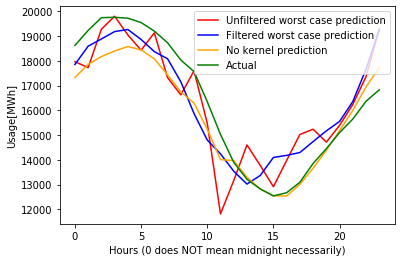

In [146]:
#plt.plot(range(-95,1), X['AEP_MW'], 'g')
plt.figure()
plt.plot(range(24), worst, 'r', label = 'Unfiltered worst case prediction') # The unfiltered data
plt.plot(range(24), savitzky_golay(worst, 9, 2),'b',label = 'Filtered worst case prediction') #The filtered data using savitzky golay
plt.plot(range(24), meanXpr,'orange', label = 'No kernel prediction') # The "mean" prediction without using the kernel at all
plt.plot(range(24), Xpr['AEP_MW'],'g', label = 'Actual') # The actual value
plt.xlabel('Hours (0 does NOT mean midnight necessarily)')
plt.ylabel('Usage[MWh]')
plt.legend()